In [1]:
#imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import numpy as np

import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols


In [2]:
#Upload data files and organize dataframes

datafile = '/home/lentilha/Desktop/fibrosis_time_proj/QIs_processed_10percentCI_withoutcontrol30 _alldata.csv'
df = pd.read_csv(datafile)


#add instillation column
df['instillation'] = np.where(df['animal'] <= 21, 'BLEO', 'PBS')

#add day column
conditions = [(df['animal'] == 3) | (df['animal'] == 4) | (df['animal'] == 7) 
| (df['animal'] == 8) | (df['animal'] == 15) | (df['animal'] == 16)
| (df['animal'] == 21) | (df['animal'] == 22)
| (df['animal'] == 27) | (df['animal'] == 28), (df['animal'] == 5) | (df['animal'] == 6) | (df['animal'] == 9) 
| (df['animal'] == 11) | (df['animal'] == 12) | (df['animal'] == 19)
| (df['animal'] == 20) | (df['animal'] == 23)
| (df['animal'] == 24) | (df['animal'] == 29), (df['animal'] == 1) | (df['animal'] == 2) | (df['animal'] == 10) 
| (df['animal'] == 13) | (df['animal'] == 14) | (df['animal'] == 17)
| (df['animal'] == 18) | (df['animal'] == 25)
| (df['animal'] == 26) | (df['animal'] == 30)]

values = [7,14,28]

df['day'] = np.select(conditions,values)


df.head(10)

#If want to export, uncomment below:

#pathfile = '/home/lentilha/Desktop/fibrosis_time_proj/outputQis.csv'
#df.to_csv(pathfile)


animal sample  map  coordinate  mean_E_log10_Pa  median_E_log10_Pa  \
0      18    L18  340           0         4.473405           4.455700   
1      18    L18  340          10         4.671768           4.658579   
2      18    L18  340          20         4.881448           4.863891   
3      18    L18  340          30         4.896889           4.895216   
4      18    L18  340          40         4.733047           4.682098   
5      18    L18  340          50         5.061662           5.074774   
6      18    L18  340          60         4.447361           4.429884   
7      18    L18  340          70         4.454758           4.464505   
8      18    L18  340           1         4.435787           4.436614   
9      18    L18  340          11         4.432873           4.453185   

   std_E_log10_Pa       Q10       Q50       Q90     Ra_um     Rq_um  \
0        0.294521  4.123721  4.455700  4.867116  0.114464  0.181298   
1        0.348489  4.212938  4.658579  5.135355  0.141822  0.269850   
2        0.314127  4.504941  4.863891  5.308133  0.418851  0.522596   
3        0.408241  4.374670  4.895216  5.422695  0.108173  0.191930   
4        0.396069  4.276600  4.682098  5.289651  1.054802  1.264240   
5        0.344805  4.588627  5.074774  5.515105  0.351514  0.430126   
6        0.151037  4.283041  4.429884  4.634131  0.428485  0.504216   
7        0.181713  4.237408  4.464505  4.674707  0.207813  0.266178   
8        0.350932  4.077659  4.436614  4.796045  0.515471  0.641661   
9        0.373310  4.067748  4.453185  4.777810  0.575598  0.667787   

  instillation  day  
0         BLEO   28  
1         BLEO   28  
2         BLEO   28  
3         BLEO   28  
4         BLEO   28  
5         BLEO   28  
6         BLEO   28  
7         BLEO   28  
8         BLEO   28  
9         BLEO   28

In [3]:
#clean
#drop rows with NaN values
df = df.dropna(axis=0)


#drop rows where Ra and Rq <= 0 um
df = df[df['Ra_um'] > 0.01] 
df = df[df['Rq_um'] > 0.01] 



#group by and nest
grouped_animal_map = df.groupby(by=['animal', 'map'])
print(grouped_animal_map.describe())



           coordinate                                                  \
                count  mean        std  min    25%   50%    75%   max   
animal map                                                              
1      140       55.0  43.6  20.905076  0.0  26.50  44.0  61.50  77.0   
       240       64.0  38.5  23.209194  0.0  19.25  38.5  57.75  77.0   
       340       64.0  38.5  23.209194  0.0  19.25  38.5  57.75  77.0   
       440       64.0  38.5  23.209194  0.0  19.25  38.5  57.75  77.0   
2      140       64.0  38.5  23.209194  0.0  19.25  38.5  57.75  77.0   
...               ...   ...        ...  ...    ...   ...    ...   ...   
28     240       64.0  38.5  23.209194  0.0  19.25  38.5  57.75  77.0   
       340       64.0  38.5  23.209194  0.0  19.25  38.5  57.75  77.0   
29     140       64.0  38.5  23.209194  0.0  19.25  38.5  57.75  77.0   
       240       64.0  38.5  23.209194  0.0  19.25  38.5  57.75  77.0   
       340       64.0  38.5  23.209194  0.0  19.25 

In [4]:
#Clean data by keeping 5-05 CI on medians

g = df.groupby(['animal','map'])['median_E_log10_Pa']
m = df['median_E_log10_Pa'].between(g.transform('quantile', 0.05), g.transform('quantile', 0.95))
r = df['Rq_um'].between(g.transform('quantile', 0.05), g.transform('quantile', 0.95))
df_cleandata_bymap = df[m]

#there's a mysterious negative Q10 somewhere 
df_cleandata_bymap = df_cleandata_bymap[df_cleandata_bymap['Q10'] > 0]

In [5]:
df_cleandata_bymap

animal sample  map  coordinate  mean_E_log10_Pa  median_E_log10_Pa  \
0         18    L18  340           0         4.473405           4.455700   
1         18    L18  340          10         4.671768           4.658579   
2         18    L18  340          20         4.881448           4.863891   
3         18    L18  340          30         4.896889           4.895216   
4         18    L18  340          40         4.733047           4.682098   
...      ...    ...  ...         ...              ...                ...   
6395       9     R9  440          37         4.853354           4.836107   
6396       9     R9  440          47         4.755810           4.766614   
6397       9     R9  440          57         4.723186           4.707032   
6398       9     R9  440          67         4.828575           4.837327   
6399       9     R9  440          77         5.130776           5.113502   

      std_E_log10_Pa       Q10       Q50       Q90     Ra_um     Rq_um  \
0           0.294521  4.123721  4.455700  4.867116  0.114464  0.181298   
1           0.348489  4.212938  4.658579  5.135355  0.141822  0.269850   
2           0.314127  4.504941  4.863891  5.308133  0.418851  0.522596   
3           0.408241  4.374670  4.895216  5.422695  0.108173  0.191930   
4           0.396069  4.276600  4.682098  5.289651  1.054802  1.264240   
...              ...       ...       ...       ...       ...       ...   
6395        0.263315  4.526611  4.836107  5.215973  0.770986  0.885420   
6396        0.251423  4.446717  4.766614  5.072040  0.489179  0.640887   
6397        0.269380  4.409016  4.707032  5.051677  0.649727  0.823209   
6398        0.219058  4.550875  4.837327  5.108250  0.596050  0.655728   
6399        0.339576  4.701594  5.113502  5.559464  0.373281  0.453342   

     instillation  day  
0            BLEO   28  
1            BLEO   28  
2            BLEO   28  
3            BLEO   28  
4            BLEO   28  
...           ...  ...  
6395         BLEO   14  
6396         BLEO   14  
6397         BLEO   14  
6398         BLEO   14  
6399         BLEO   14  

[5414 rows x 14 columns]

In [6]:
#pathfile_cleandatabymap = '/home/lentilha/Desktop/fibrosis_time_proj/outpuCleanDataByMap.csv'
#df_cleandata_bymap.to_csv(pathfile_cleandatabymap)

Text(0.5, 1.0, 'Mean and Roughness Total Correlation')

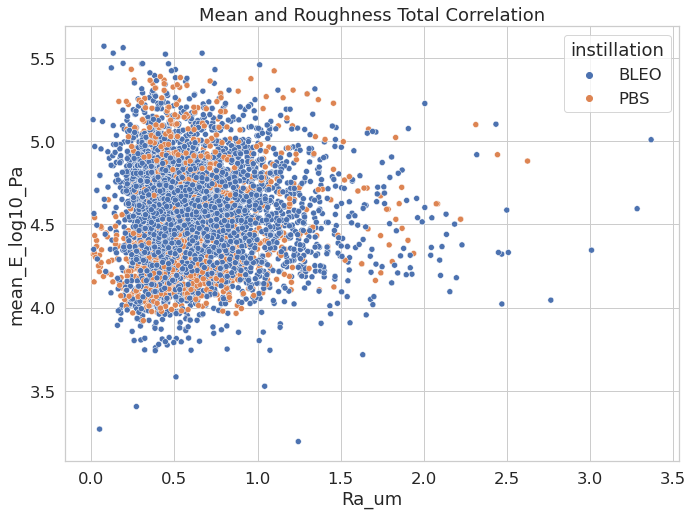

In [7]:
#plot 
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

sns.scatterplot(data=df_cleandata_bymap, y="mean_E_log10_Pa", x="Ra_um", hue="instillation").set_title('Mean and Roughness Total Correlation')



Text(0.5, 1.0, 'Median and Roughness Total Correlation')

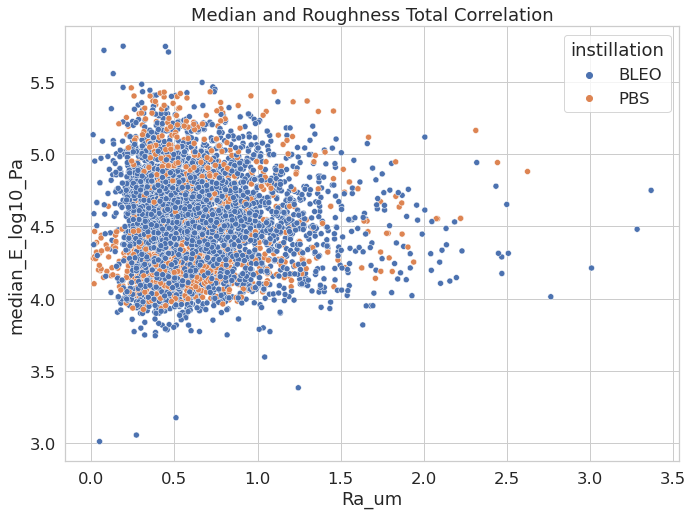

In [8]:
sns.scatterplot(data=df_cleandata_bymap, y="median_E_log10_Pa", x="Ra_um", hue="instillation").set_title('Median and Roughness Total Correlation')

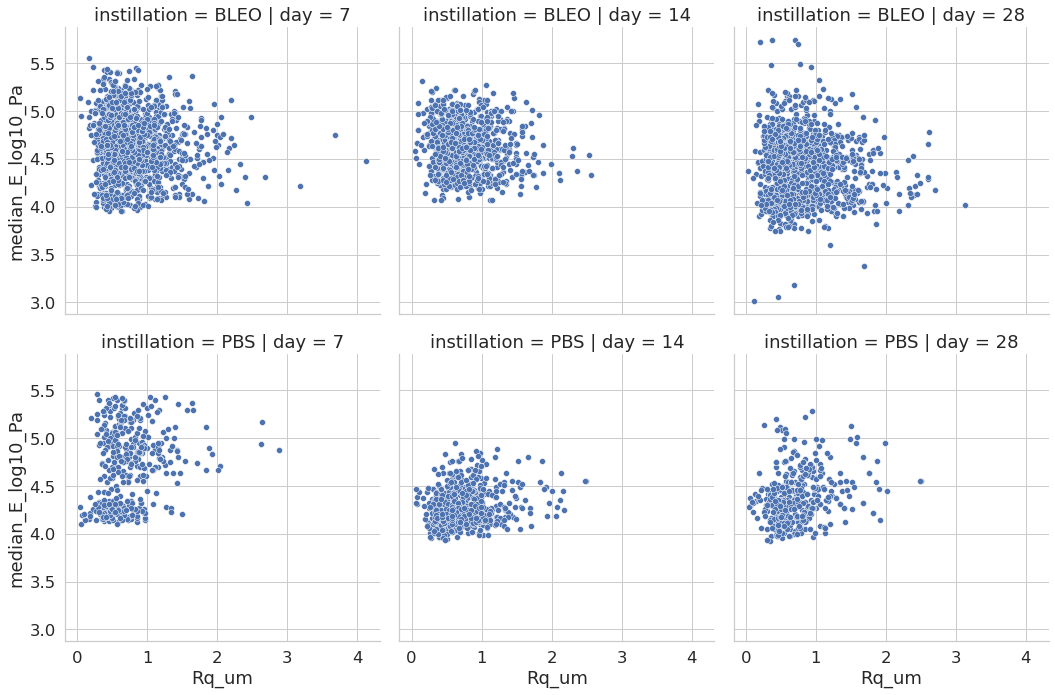

In [9]:
sns.relplot(
    data=df_cleandata_bymap, y="median_E_log10_Pa", x="Rq_um",
    col="day", row='instillation',
    kind="scatter"
)

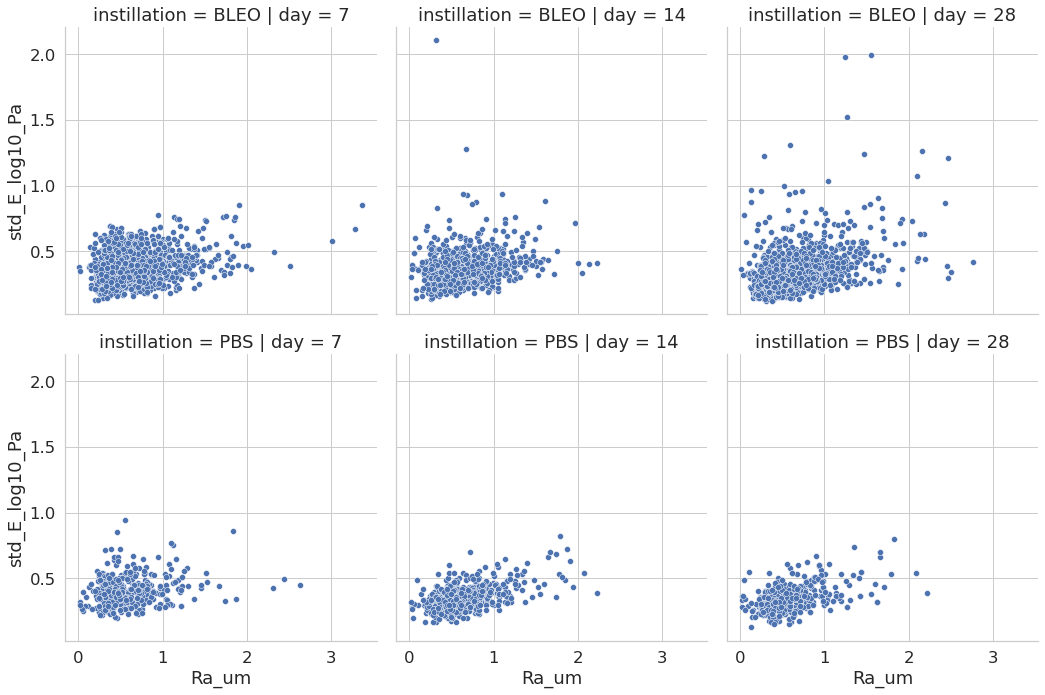

In [10]:
sns.relplot(
    data=df_cleandata_bymap, y="std_E_log10_Pa", x="Ra_um",
    col="day", row='instillation',
    kind="scatter"
)

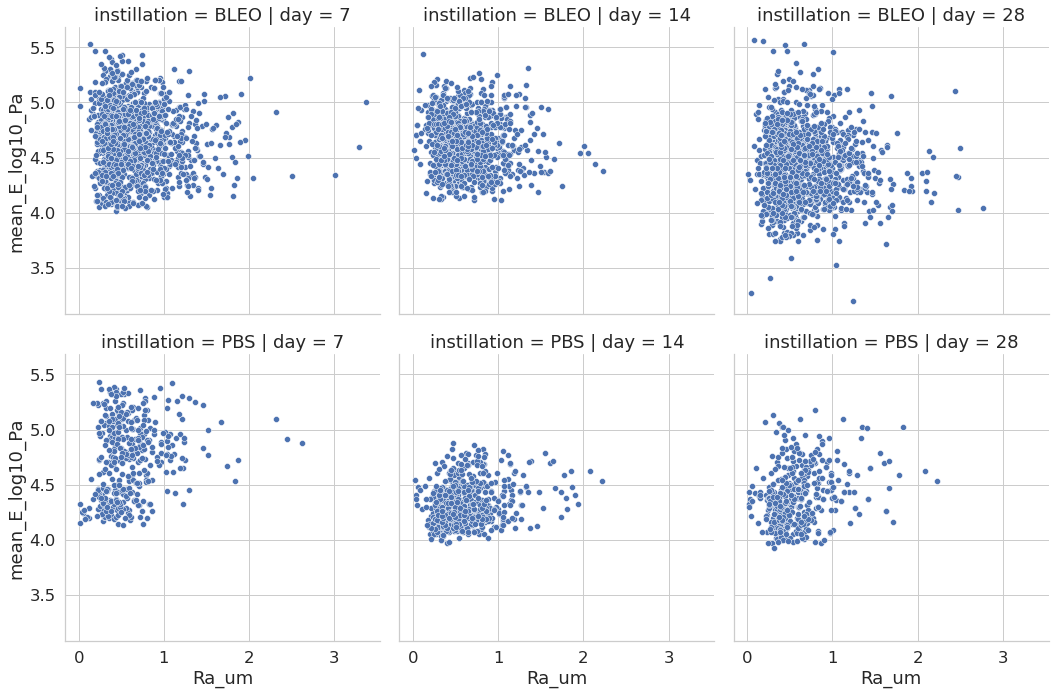

In [11]:
sns.relplot(
    data=df_cleandata_bymap, y="mean_E_log10_Pa", x="Ra_um",
    col="day", row='instillation',
    kind="scatter"
)

Text(0.5, 1.0, 'Correlation Matrix Pearson')

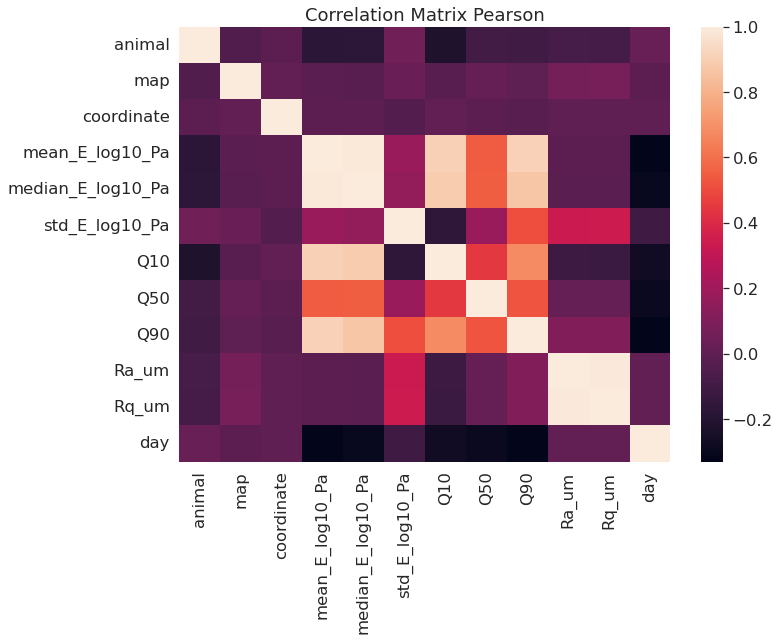

In [12]:
corrMatrix = df_cleandata_bymap.corr(method='pearson')

sns.heatmap(corrMatrix, robust=True, cmap=None).set_title('Correlation Matrix Pearson')

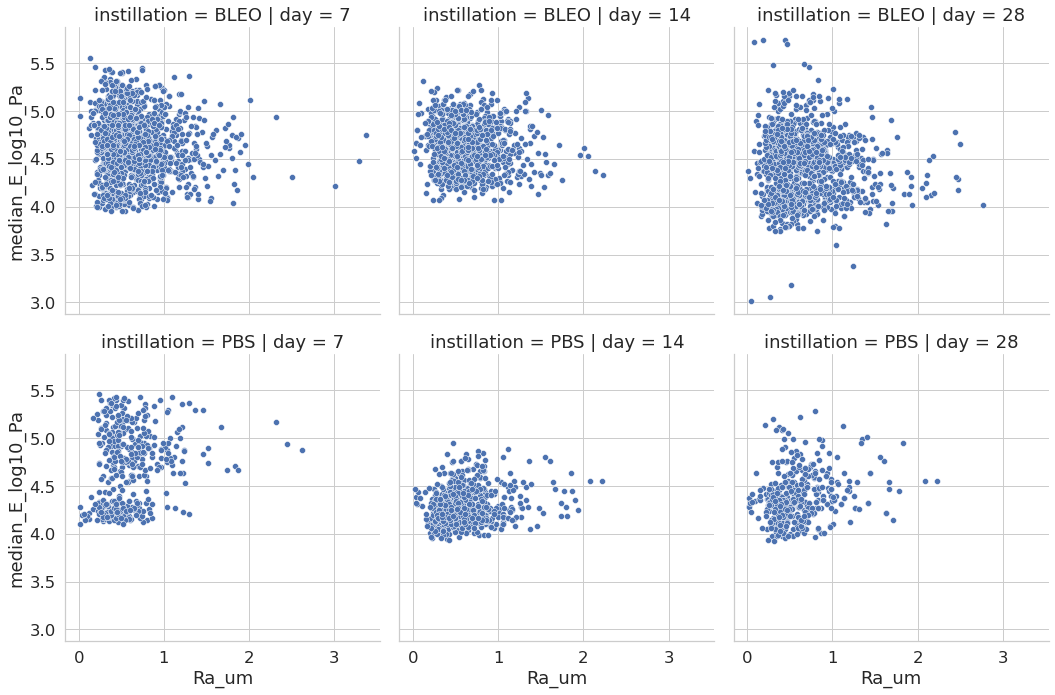

In [13]:
sns.relplot(
    data=df_cleandata_bymap, y="median_E_log10_Pa", x="Ra_um",
    col="day", row='instillation',
    kind="scatter"
)

In [14]:
#Clean data
#keep only data with CI 5-95 from the force maps per animal 
#res = df.groupby('animal')["mean_E_log10_Pa"].quantile([0.05, 0.95]).unstack(level=1)
#restest = grouped_animal_map['median_E_log10_Pa'].quantile([0.05, 0.95]).unstack(level=1)
#print(restest)


#df_removed_outliers_byroughness = df.loc[ ((res.loc[ df['animal'], 0.05] < df['mean_E_log10_Pa'].values) & (df['mean_E_log10_Pa'].values < res.loc[df['animal'], 0.95])).values]
#df_removed_outliers_byroughness.head(10)
#df_cleandata_bymap = df.loc[ ((restest.loc[ df['animal'], 0.05] < df['mean_E_log10_Pa'].values) & (df['mean_E_log10_Pa'].values < restest.loc[df['animal'], 0.95])).values]
#grouped_animal_map = grouped_animal_map.count()['median_E_log10_Pa'].unstack(level=1)


#df_removed_outliers_test = grouped_animal_map.loc[ ((restest.loc[ grouped_animal_map['map'], 0.05] < grouped_animal_map['map'].values) & (grouped_animal_map['map'].values < restest.loc[grouped_animal_map['map'], 0.95])).values]

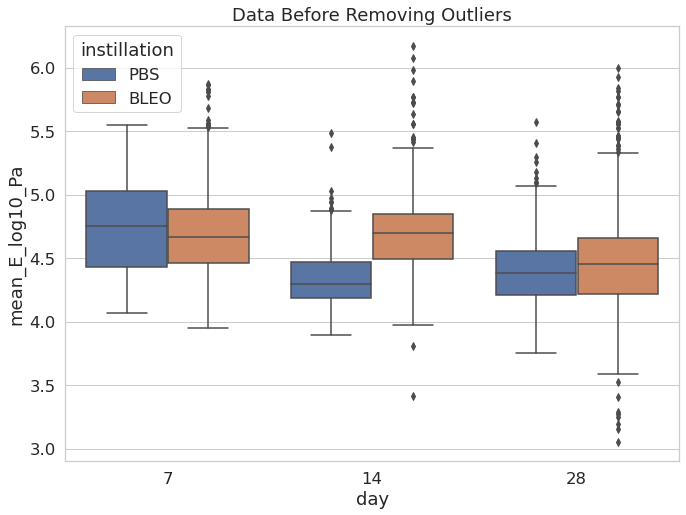

In [15]:
#plot boxplot 
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

bp = sns.boxplot(data=df, x="day", y="mean_E_log10_Pa", hue="instillation", hue_order=['PBS','BLEO'], dodge=True).set_title('Data Before Removing Outliers')

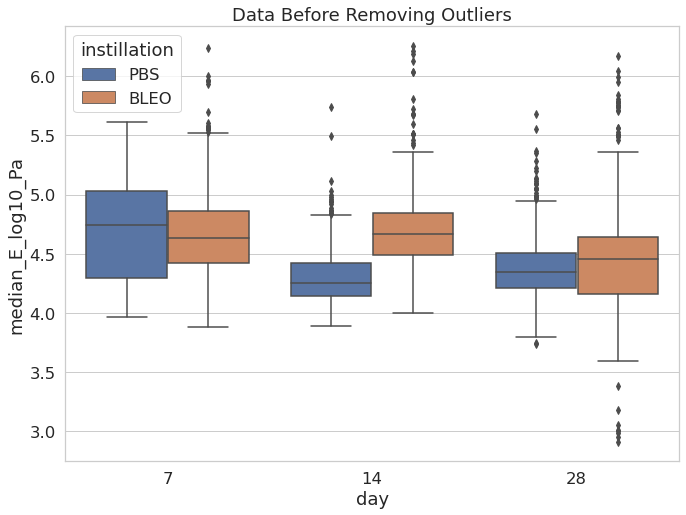

In [16]:
#plot boxplot 
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

bp = sns.boxplot(data=df, x="day", y="median_E_log10_Pa", hue="instillation", hue_order=['PBS','BLEO'], dodge=True).set_title('Data Before Removing Outliers')

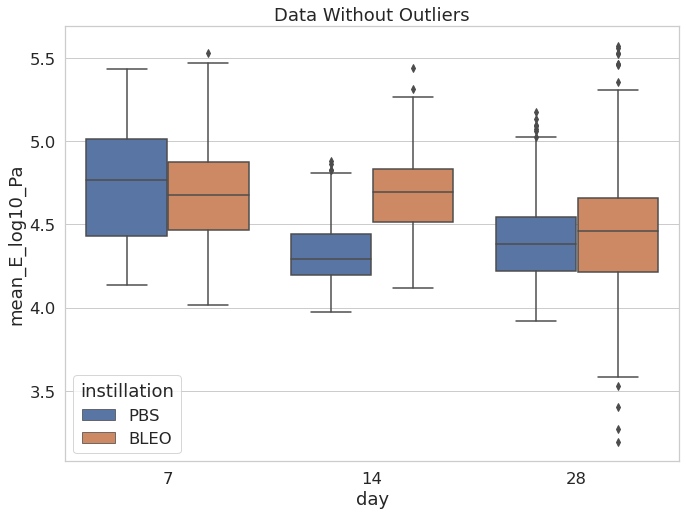

In [17]:
#plot boxplot 
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

bp = sns.boxplot(data=df_cleandata_bymap, x="day", y="mean_E_log10_Pa", hue="instillation", hue_order=['PBS','BLEO'], dodge=True).set_title('Data Without Outliers')

Text(0, 0.5, 'Distribution of median per tile in log10 E (Pa)')

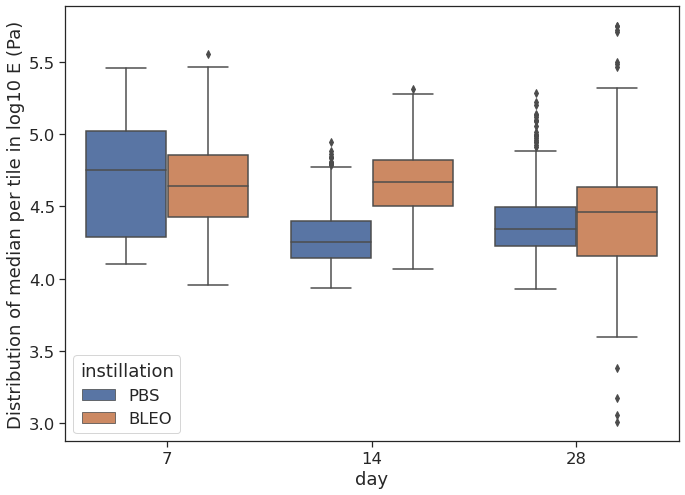

In [18]:
#plot boxplot 
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='ticks')

bp = sns.boxplot(data=df_cleandata_bymap, x="day", y="median_E_log10_Pa", hue="instillation", hue_order=['PBS','BLEO'], dodge=True)
bp.set_xlabel('day')
bp.set_ylabel('Distribution of median per tile in log10 E (Pa)')
#.set_axis_labels("day)", "Distribution of median per tile in log10 E (Pa)")


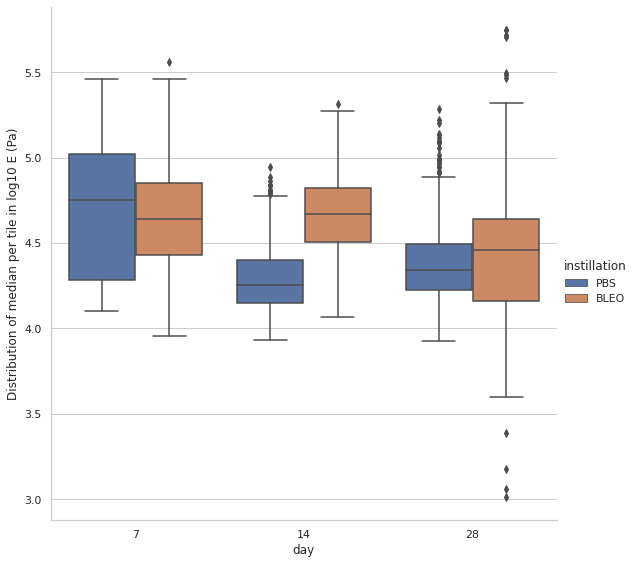

In [19]:
sns.set_theme(style="whitegrid")


br = sns.catplot(data=df_cleandata_bymap, kind='box', x="day", y="median_E_log10_Pa", hue="instillation", hue_order=['PBS','BLEO'], height=8)
br.set_axis_labels("day", "Distribution of median per tile in log10 E (Pa)")



In [20]:
#df_cleandata_bymap['median_E_Pa'] = np.power(10, df_cleandata_bymap['median_E_log10_Pa'])
df_cleandata_bymap.head()

#group by and nest
a_grouped_bystatus_day = df_cleandata_bymap.groupby(by=['instillation', 'day'])
print(a_grouped_bystatus_day['Rq_um'].median())
print(a_grouped_bystatus_day['Rq_um'].quantile(q=0.25))
print(a_grouped_bystatus_day['Rq_um'].quantile(q=0.75))

instillation  day
BLEO          7      0.698114
              14     0.656287
              28     0.682846
PBS           7      0.640439
              14     0.666785
              28     0.659283
Name: Rq_um, dtype: float64
instillation  day
BLEO          7      0.505710
              14     0.486483
              28     0.479848
PBS           7      0.465475
              14     0.494694
              28     0.459671
Name: Rq_um, dtype: float64
instillation  day
BLEO          7      0.964684
              14     0.917581
              28     0.985357
PBS           7      0.896852
              14     0.941845
              28     0.898660
Name: Rq_um, dtype: float64


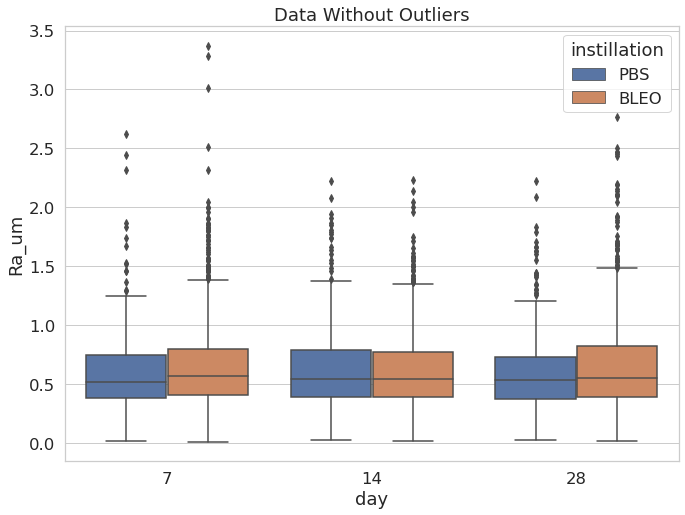

In [21]:
#plot boxplot 
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

bp = sns.boxplot(data=df_cleandata_bymap, x="day", y="Ra_um", hue="instillation", hue_order=['PBS','BLEO'], dodge=True).set_title('Data Without Outliers')


Text(0, 0.5, 'Distribution of median per tile in Rq (um)')

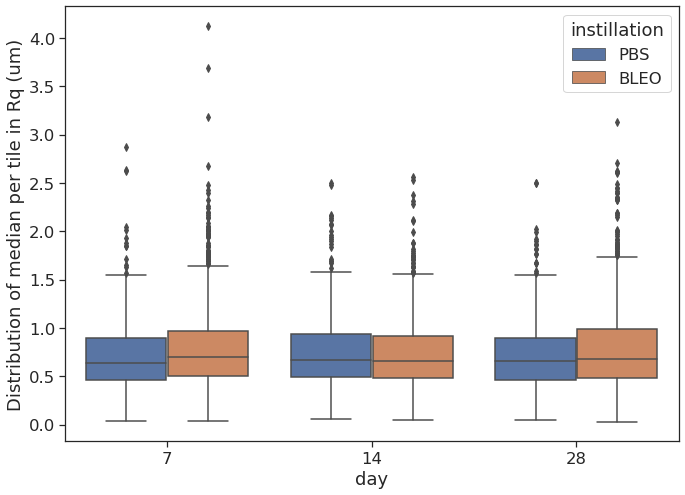

In [22]:
#plot boxplot 
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='ticks')

bp = sns.boxplot(data=df_cleandata_bymap, x="day", y="Rq_um", hue="instillation", hue_order=['PBS','BLEO'], dodge=True)
bp.set_ylabel('Distribution of median per tile in Rq (um)')

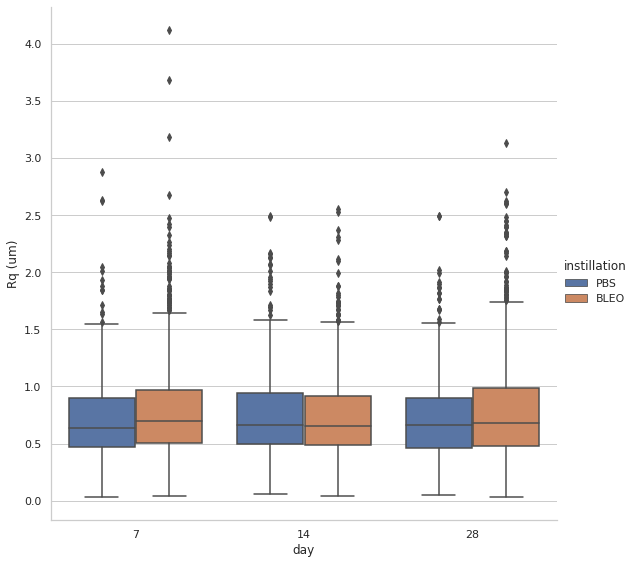

In [23]:
sns.set_theme(style="whitegrid")


br = sns.catplot(data=df_cleandata_bymap, kind='box', x="day", y="Rq_um", hue="instillation", hue_order=['PBS','BLEO'], height=8)
br.set_axis_labels("day", "Rq (um)")



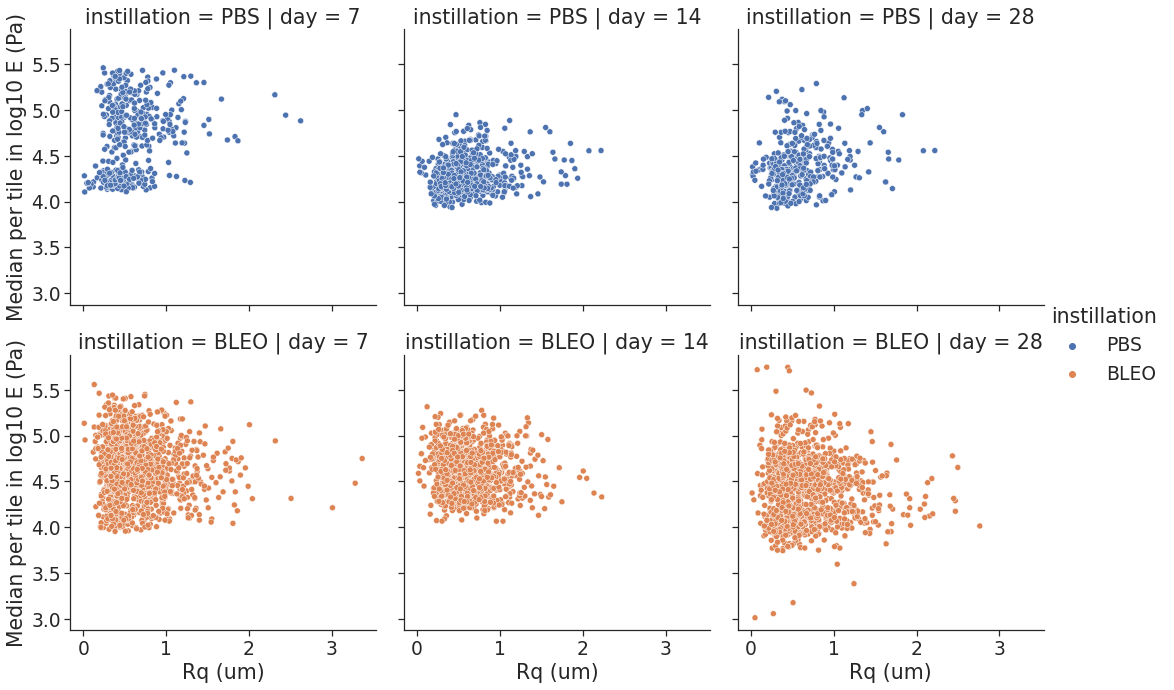

In [24]:
#plot boxplot 
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.7, style='ticks')

g = sns.relplot(
    data=df_cleandata_bymap, y="median_E_log10_Pa", x="Ra_um",
    col="day", row='instillation',
    kind="scatter", hue='instillation', hue_order=['PBS','BLEO'], row_order=['PBS','BLEO']
)

g.set_axis_labels("Rq (um)", "Median per tile in log10 E (Pa)")


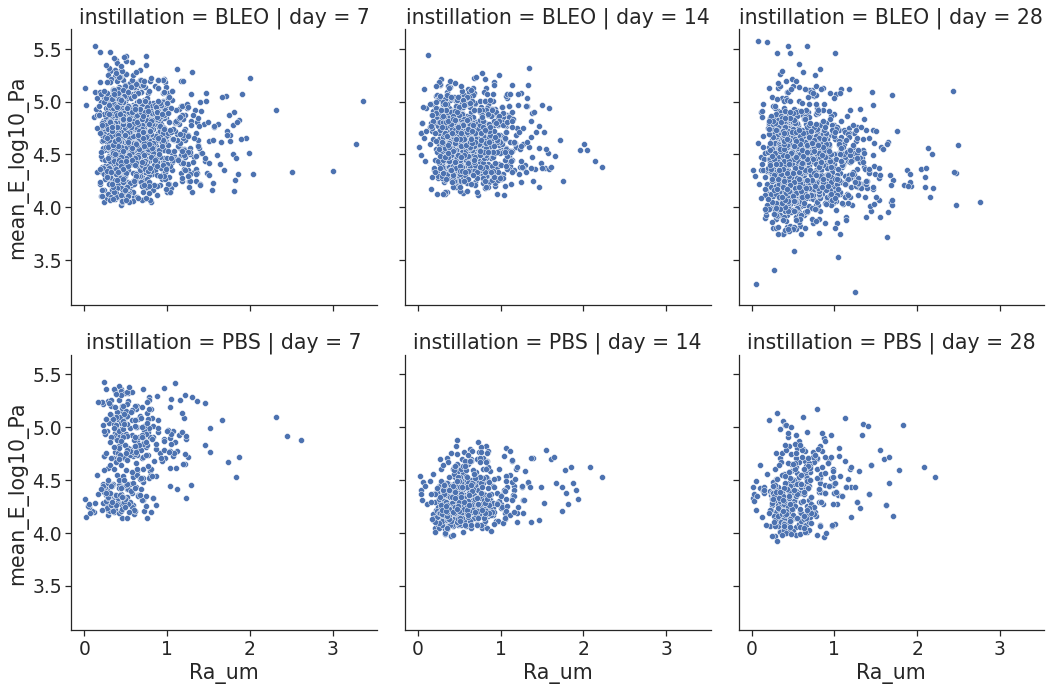

In [25]:
sns.relplot(
    data=df_cleandata_bymap, y="mean_E_log10_Pa", x="Ra_um",
    col="day", row='instillation',
    kind="scatter"
)

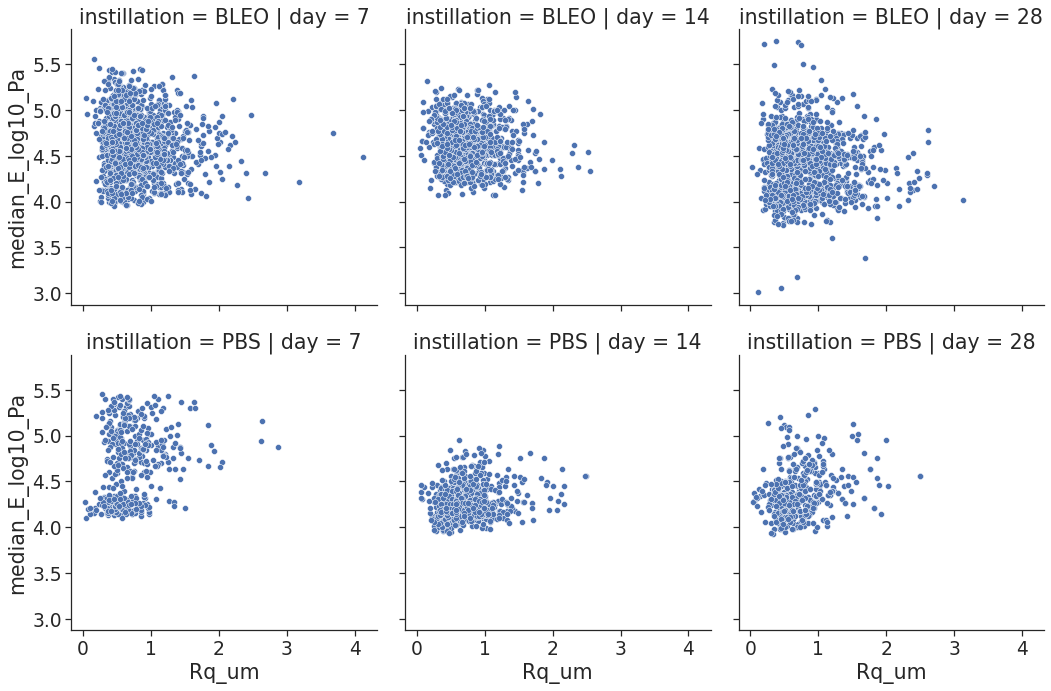

In [26]:
sns.relplot(
    data=df_cleandata_bymap, y="median_E_log10_Pa", x="Rq_um",
    col="day", row='instillation',
    kind="scatter"
)

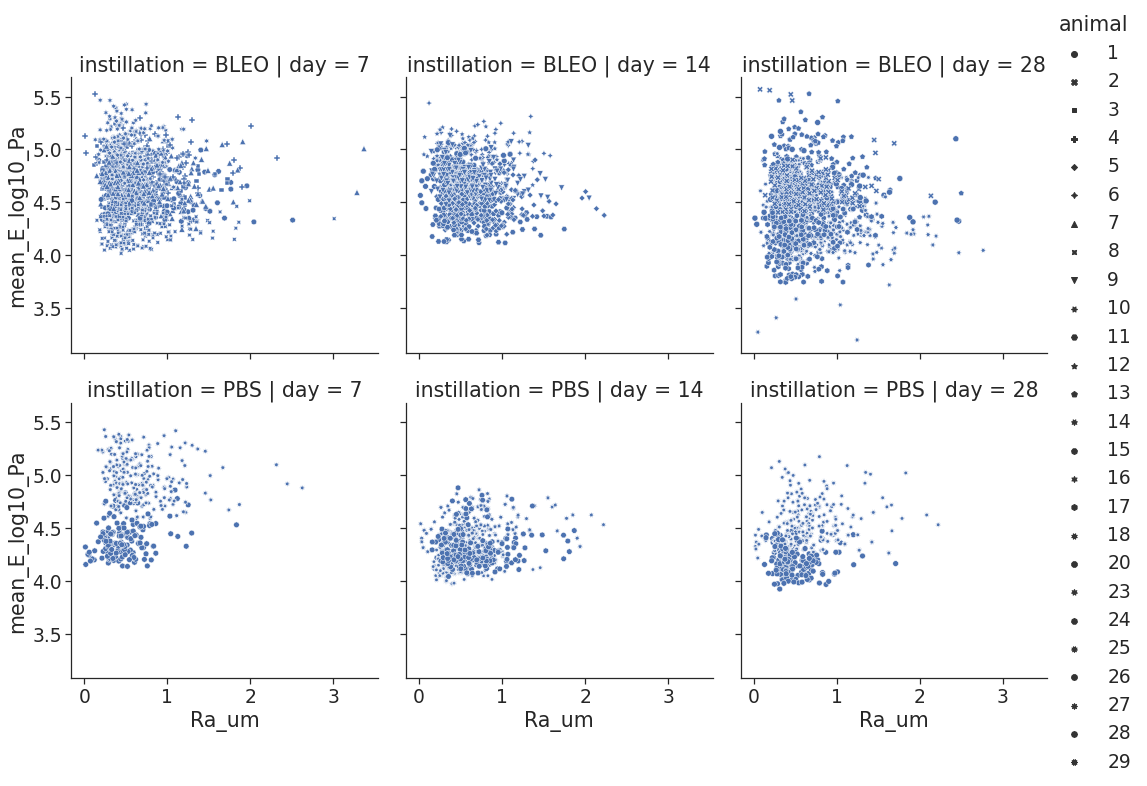

In [27]:
sns.relplot(
    data=df_cleandata_bymap, y="mean_E_log10_Pa", x="Ra_um",
    col="day", row='instillation',
    kind="scatter", style='animal'
)

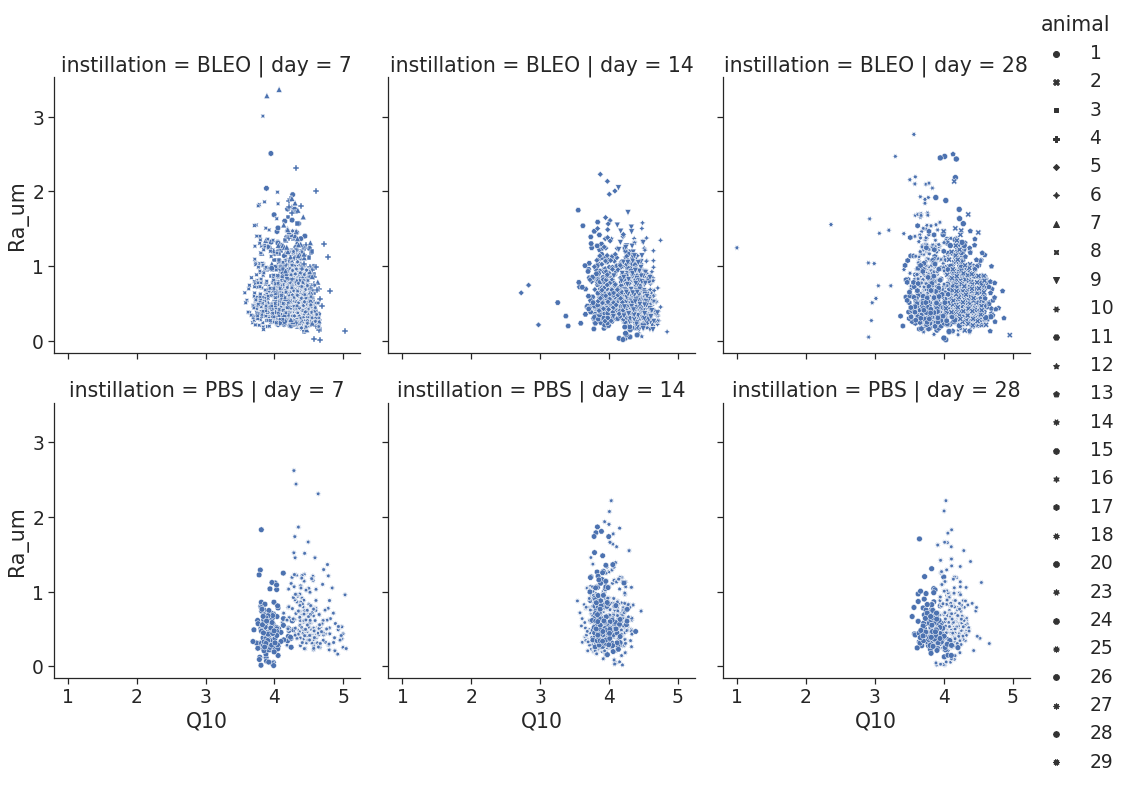

In [28]:
sns.relplot(
    data=df_cleandata_bymap, x="Q10", y="Ra_um",
    col="day", row='instillation',
    kind="scatter", style='animal'
)

Text(0.5, 1.0, 'Correlation Matrix After Removing Outliers By Map 5-95% CI by median')

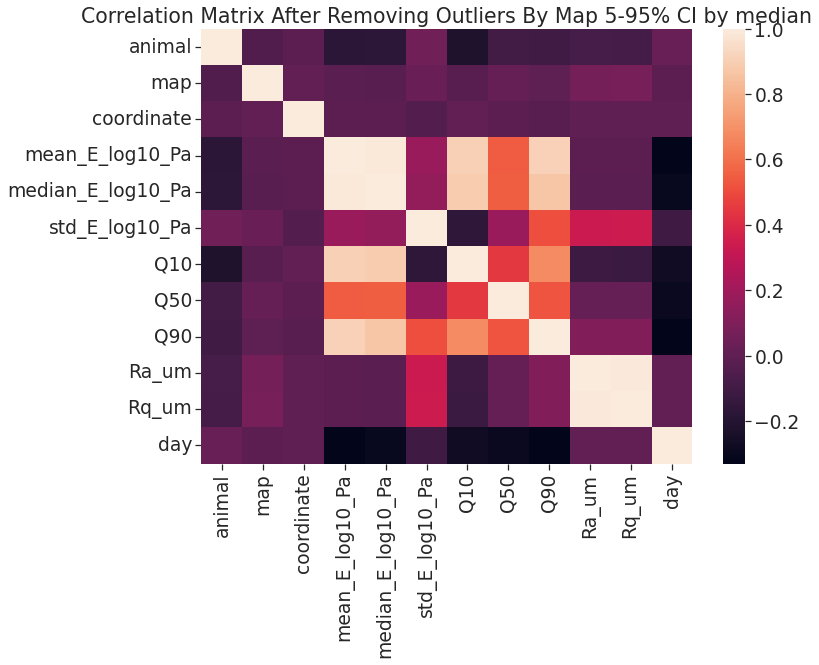

In [29]:
corrMatrix_nooutliers = df_cleandata_bymap.corr()

sns.heatmap(corrMatrix_nooutliers, robust=True, cmap=None).set_title('Correlation Matrix After Removing Outliers By Map 5-95% CI by median')

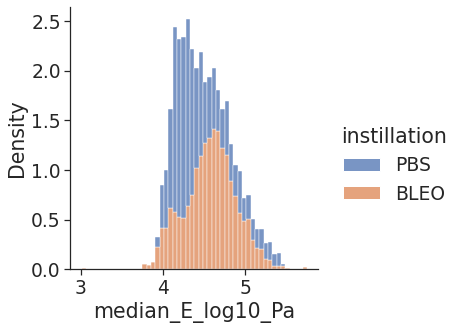

In [30]:
sns.displot(df_cleandata_bymap, x="median_E_log10_Pa", hue="instillation", multiple="stack", stat="density", common_norm=False, hue_order=['PBS','BLEO'])

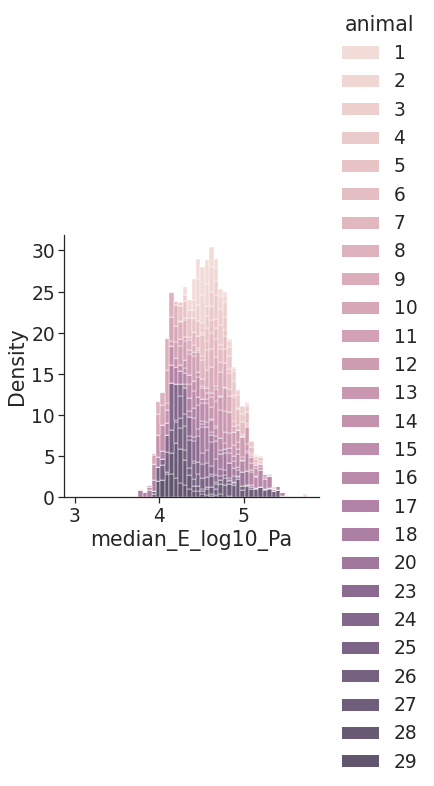

In [31]:
sns.displot(df_cleandata_bymap, x="median_E_log10_Pa", hue="animal", multiple="stack", stat="density", common_norm=False)

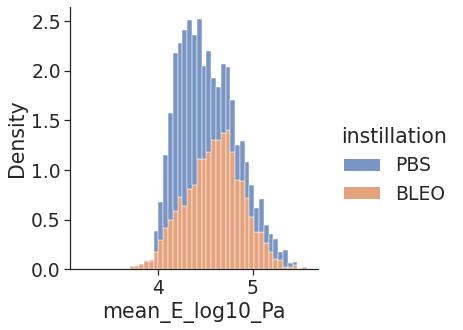

In [32]:
sns.displot(df_cleandata_bymap, x="mean_E_log10_Pa", hue="instillation", multiple="stack", stat="density", common_norm=False, hue_order=['PBS','BLEO'])

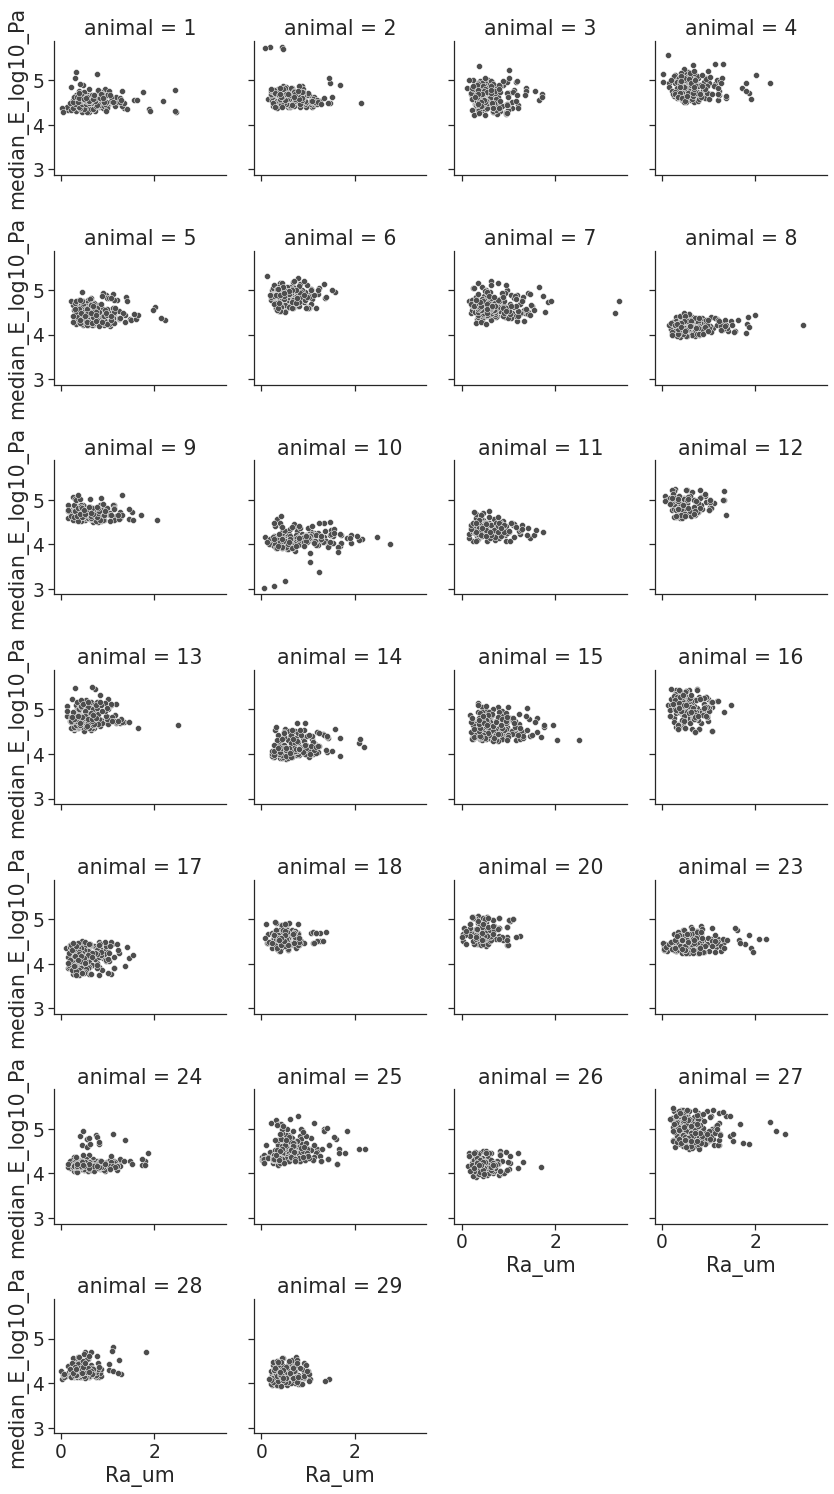

In [33]:
g = sns.FacetGrid(df_cleandata_bymap, col="animal", col_wrap=4)
g.map(sns.scatterplot, "Ra_um", "median_E_log10_Pa", color=".3", ci=None)

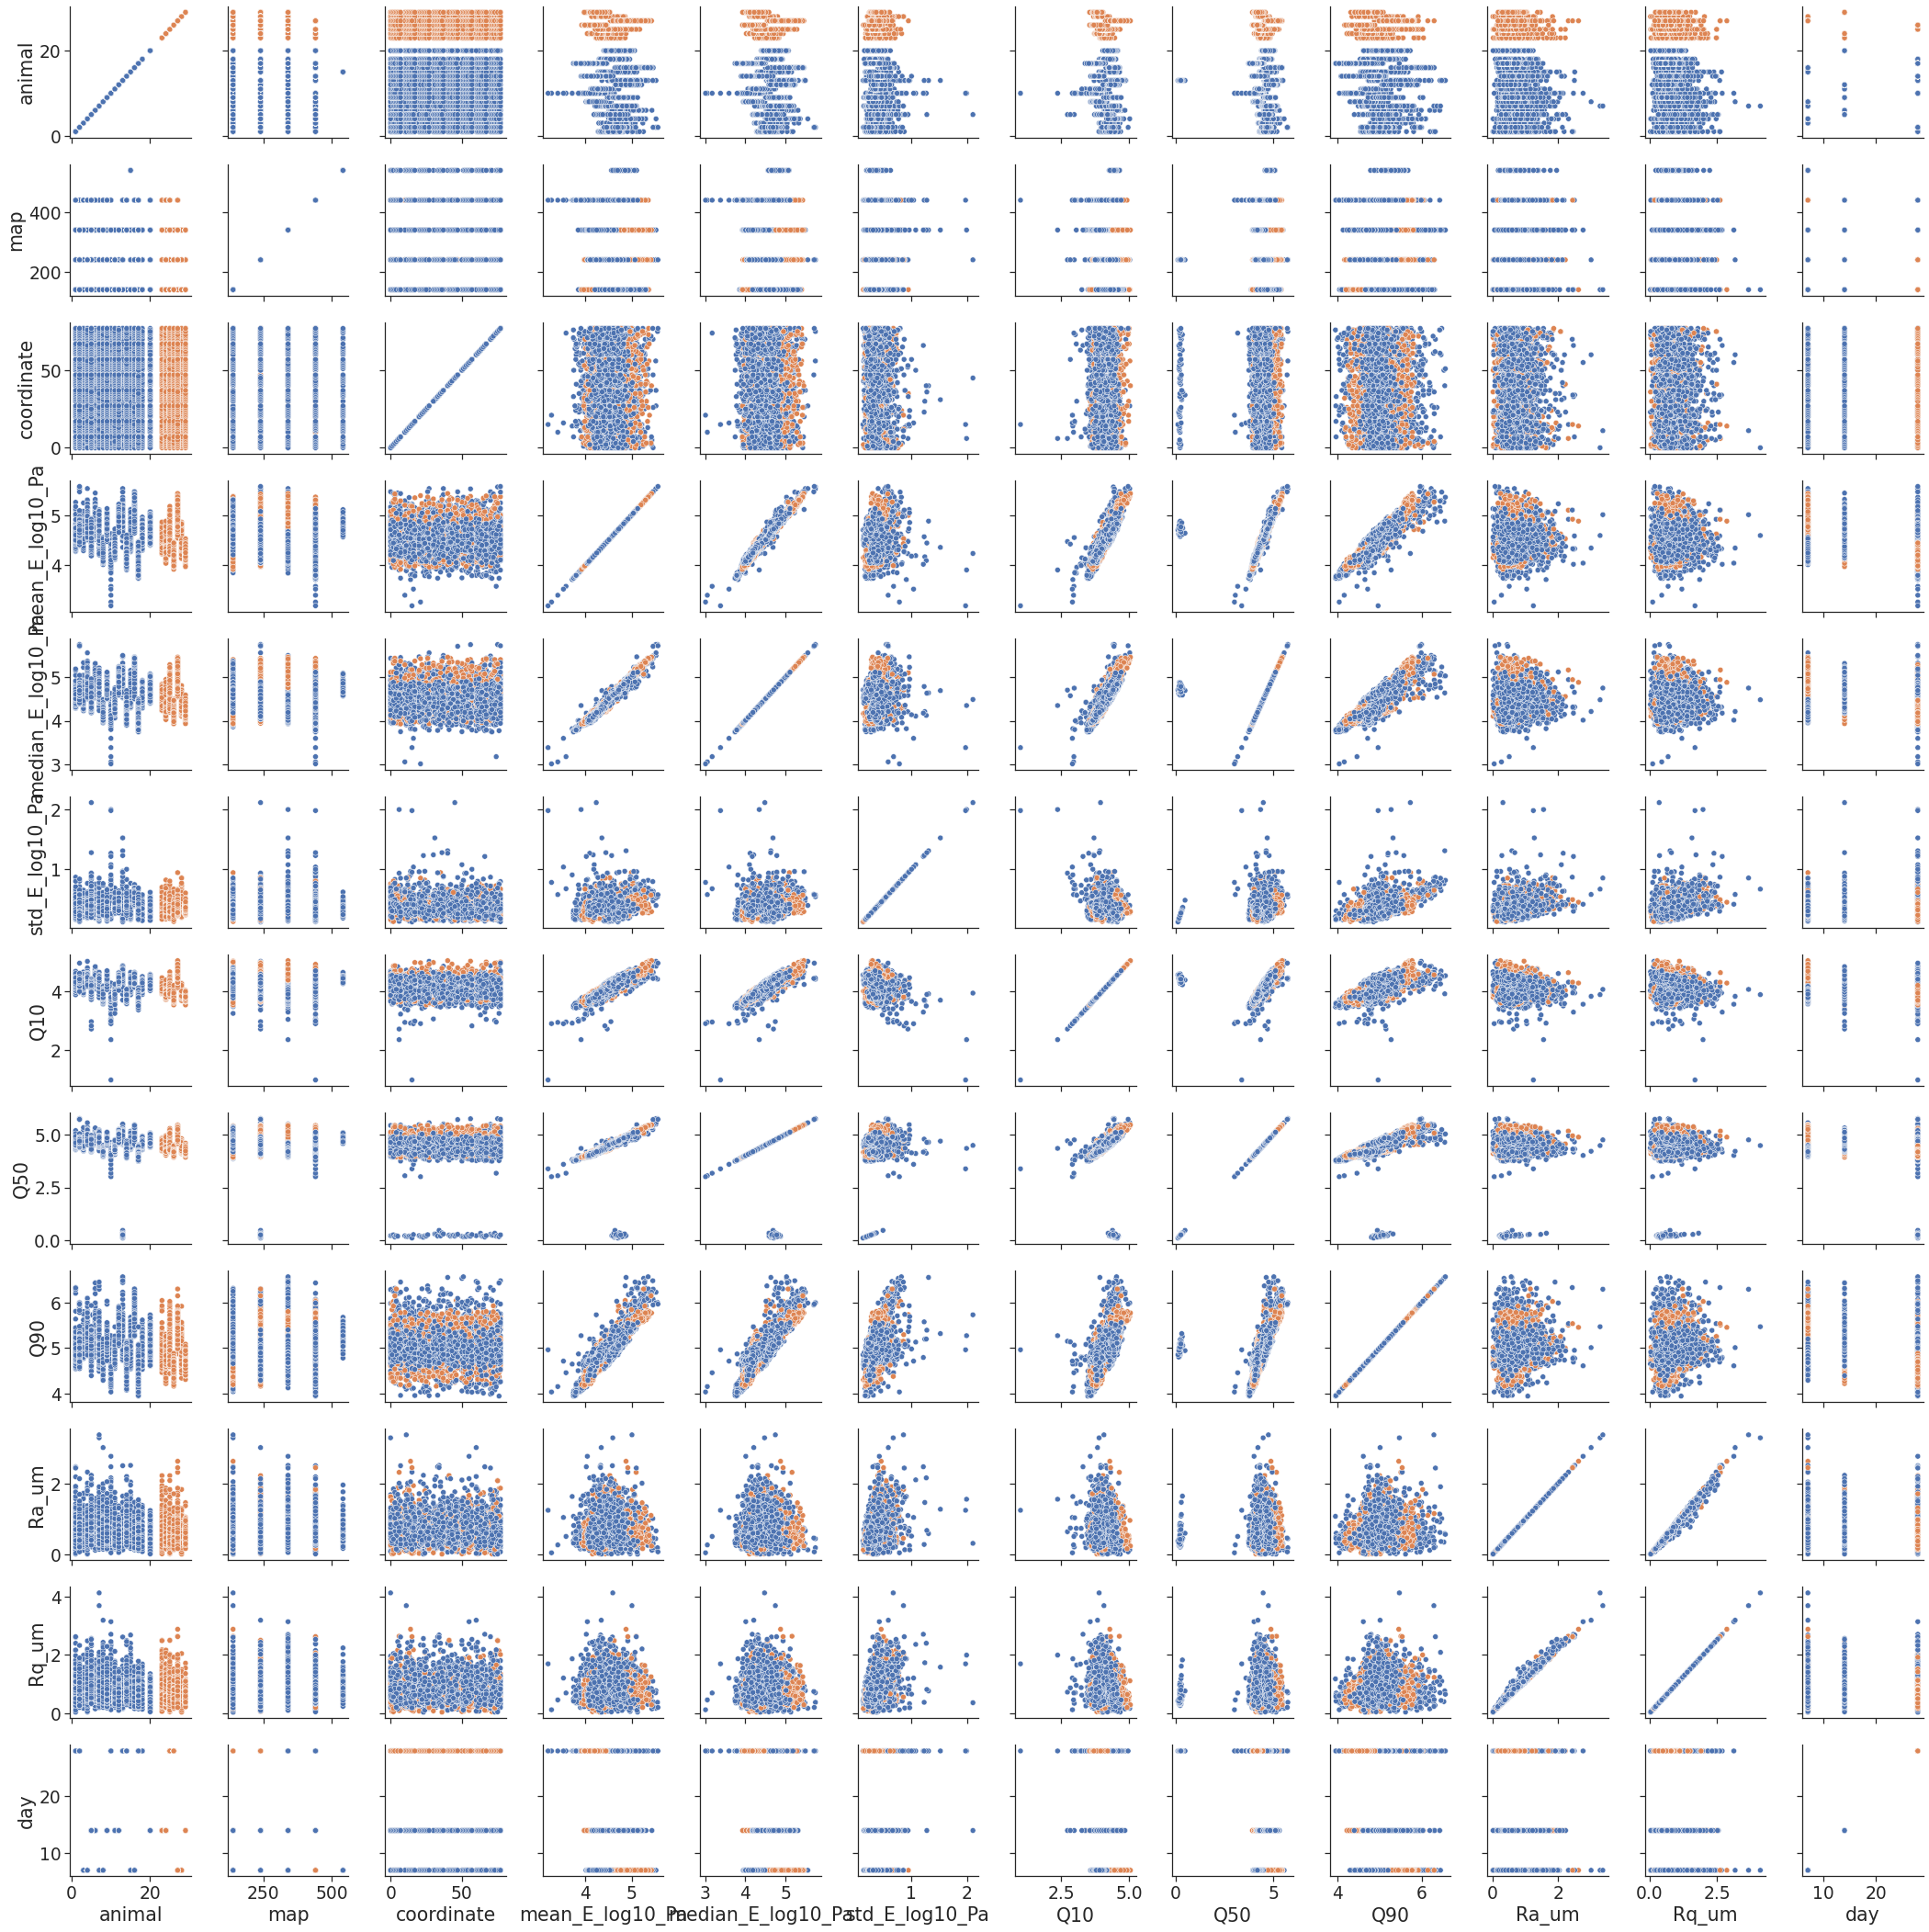

In [34]:
g = sns.PairGrid(df_cleandata_bymap, hue='instillation')
g.map(sns.scatterplot)

In [35]:
#separate
datafile_onlypbs = '/home/lentilha/Desktop/fibrosis_time_proj/outputQis_onlyPBS.csv'
df_onlypbs = pd.read_csv(datafile_onlypbs)

datafile_onlybleo = '/home/lentilha/Desktop/fibrosis_time_proj/outputQis_onlyBLEO.csv'
df_onlybleo = pd.read_csv(datafile_onlybleo)

In [36]:
corrMatrix_onlybleo = df_onlybleo.corr(method = 'pearson')
corrMatrix_onlybleo
#sns.heatmap(corrMatrix_onlybleo, robust=True, cmap=None).set_title('Correlation Matrix For Bleo')

animal       map  coordinate  mean_E_log10_Pa  \
animal             1.000000 -0.041316   -0.011731        -0.057939   
map               -0.041316  1.000000    0.001717        -0.093962   
coordinate        -0.011731  0.001717    1.000000        -0.018056   
mean_E_log10_Pa   -0.057939 -0.093962   -0.018056         1.000000   
median_E_log10_Pa -0.036947 -0.099216   -0.016167         0.984283   
std_E_log10_Pa     0.088926  0.022288   -0.048546         0.122586   
Q10               -0.122906 -0.084451    0.002816         0.822287   
Q50               -0.080690 -0.009985   -0.013063         0.476523   
Q90               -0.006760 -0.077251   -0.040187         0.900574   
Ra_um             -0.100192  0.050330   -0.002329        -0.078466   
Rq_um             -0.103513  0.053300   -0.003832        -0.082797   
day                0.092379 -0.019234   -0.001124        -0.342318   

                   median_E_log10_Pa  std_E_log10_Pa       Q10       Q50  \
animal                     -0.036947        0.088926 -0.122906 -0.080690   
map                        -0.099216        0.022288 -0.084451 -0.009985   
coordinate                 -0.016167       -0.048546  0.002816 -0.013063   
mean_E_log10_Pa             0.984283        0.122586  0.822287  0.476523   
median_E_log10_Pa           1.000000        0.139790  0.777106  0.480906   
std_E_log10_Pa              0.139790        1.000000 -0.339589  0.167264   
Q10                         0.777106       -0.339589  1.000000  0.325561   
Q50                         0.480906        0.167264  0.325561  1.000000   
Q90                         0.866359        0.475467  0.570478  0.470823   
Ra_um                      -0.090032        0.289981 -0.155331 -0.009782   
Rq_um                      -0.093275        0.296782 -0.161992 -0.008745   
day                        -0.323377       -0.084539 -0.244914 -0.303409   

                        Q90     Ra_um     Rq_um       day  
animal            -0.006760 -0.100192 -0.103513  0.092379  
map               -0.077251  0.050330  0.053300 -0.019234  
coordinate        -0.040187 -0.002329 -0.003832 -0.001124  
mean_E_log10_Pa    0.900574 -0.078466 -0.082797 -0.342318  
median_E_log10_Pa  0.866359 -0.090032 -0.093275 -0.323377  
std_E_log10_Pa     0.475467  0.289981  0.296782 -0.084539  
Q10                0.570478 -0.155331 -0.161992 -0.244914  
Q50                0.470823 -0.009782 -0.008745 -0.303409  
Q90                1.000000  0.049287  0.047500 -0.347055  
Ra_um              0.049287  1.000000  0.991252  0.008532  
Rq_um              0.047500  0.991252  1.000000  0.008410  
day               -0.347055  0.008532  0.008410  1.000000

In [37]:
corrMatrix_onlypbs = df_onlypbs.corr(method = 'pearson')
corrMatrix_onlypbs

#sns.heatmap(corrMatrix_onlypbs, robust=True, cmap=None).set_title('Correlation Matrix For PBS')

animal       map  coordinate  mean_E_log10_Pa  \
animal             1.000000 -0.178047   -0.014696         0.019851   
map               -0.178047  1.000000    0.012073         0.187003   
coordinate        -0.014696  0.012073    1.000000         0.014130   
mean_E_log10_Pa    0.019851  0.187003    0.014130         1.000000   
median_E_log10_Pa  0.022906  0.178522    0.011926         0.985820   
std_E_log10_Pa     0.127457  0.100295   -0.017711         0.305773   
Q10               -0.064011  0.151149    0.028757         0.933993   
Q50                0.022906  0.178522    0.011926         0.985820   
Q90                0.061125  0.206949    0.006756         0.923403   
Ra_um             -0.151340  0.110287    0.011877         0.171108   
Rq_um             -0.157500  0.119303    0.008859         0.177586   
day               -0.305896  0.027704    0.011614        -0.316072   

                   median_E_log10_Pa  std_E_log10_Pa       Q10       Q50  \
animal                      0.022906        0.127457 -0.064011  0.022906   
map                         0.178522        0.100295  0.151149  0.178522   
coordinate                  0.011926       -0.017711  0.028757  0.011926   
mean_E_log10_Pa             0.985820        0.305773  0.933993  0.985820   
median_E_log10_Pa           1.000000        0.241209  0.932141  1.000000   
std_E_log10_Pa              0.241209        1.000000  0.024812  0.241209   
Q10                         0.932141        0.024812  1.000000  0.932141   
Q50                         1.000000        0.241209  0.932141  1.000000   
Q90                         0.867919        0.578129  0.762323  0.867919   
Ra_um                       0.164691        0.389882  0.055184  0.164691   
Rq_um                       0.171402        0.396977  0.061382  0.171402   
day                        -0.269777       -0.205086 -0.281061 -0.269777   

                        Q90     Ra_um     Rq_um       day  
animal             0.061125 -0.151340 -0.157500 -0.305896  
map                0.206949  0.110287  0.119303  0.027704  
coordinate         0.006756  0.011877  0.008859  0.011614  
mean_E_log10_Pa    0.923403  0.171108  0.177586 -0.316072  
median_E_log10_Pa  0.867919  0.164691  0.171402 -0.269777  
std_E_log10_Pa     0.578129  0.389882  0.396977 -0.205086  
Q10                0.762323  0.055184  0.061382 -0.281061  
Q50                0.867919  0.164691  0.171402 -0.269777  
Q90                1.000000  0.250874  0.256910 -0.375536  
Ra_um              0.250874  1.000000  0.992930 -0.010467  
Rq_um              0.256910  0.992930  1.000000 -0.009247  
day               -0.375536 -0.010467 -0.009247  1.000000

In [38]:
covMatrix_onlybleo = df_onlybleo.cov()
covMatrix_onlybleo

animal           map  coordinate  mean_E_log10_Pa  \
animal             30.255982    -25.394073   -1.471982        -0.096717   
map               -25.394073  12485.851962    4.376464        -3.186313   
coordinate         -1.471982      4.376464  520.361684        -0.124998   
mean_E_log10_Pa    -0.096717     -3.186313   -0.124998         0.092099   
median_E_log10_Pa  -0.064375     -3.511784   -0.116819         0.094620   
std_E_log10_Pa      0.069662      0.354683   -0.157712         0.005298   
Q10                -0.216221     -3.018105    0.020542         0.079812   
Q50                -0.265447     -0.667299   -0.178214         0.086490   
Q90                -0.013695     -3.179476   -0.337657         0.100667   
Ra_um              -0.191832      1.957598   -0.018493        -0.008289   
Rq_um              -0.226093      2.364938   -0.034706        -0.009978   
day                 4.573373    -19.343965   -0.230787        -0.935004   

                   median_E_log10_Pa  std_E_log10_Pa       Q10       Q50  \
animal                     -0.064375        0.069662 -0.216221 -0.265447   
map                        -3.511784        0.354683 -3.018105 -0.667299   
coordinate                 -0.116819       -0.157712  0.020542 -0.178214   
mean_E_log10_Pa             0.094620        0.005298  0.079812  0.086490   
median_E_log10_Pa           0.100340        0.006306  0.078729  0.091107   
std_E_log10_Pa              0.006306        0.020283 -0.015468  0.014247   
Q10                         0.078729       -0.015468  0.102291  0.062274   
Q50                         0.091107        0.014247  0.062274  0.357691   
Q90                         0.101083        0.024942  0.067205  0.103718   
Ra_um                      -0.009927        0.014375 -0.017293 -0.002036   
Rq_um                      -0.011732        0.016784 -0.020573 -0.002077   
day                        -0.921938       -0.108361 -0.705000 -1.633199   

                        Q90     Ra_um     Rq_um        day  
animal            -0.013695 -0.191832 -0.226093   4.573373  
map               -3.179476  1.957598  2.364938 -19.343965  
coordinate        -0.337657 -0.018493 -0.034706  -0.230787  
mean_E_log10_Pa    0.100667 -0.008289 -0.009978  -0.935004  
median_E_log10_Pa  0.101083 -0.009927 -0.011732  -0.921938  
std_E_log10_Pa     0.024942  0.014375  0.016784  -0.108361  
Q10                0.067205 -0.017293 -0.020573  -0.705000  
Q50                0.103718 -0.002036 -0.002077  -1.633199  
Q90                0.135671  0.006319  0.006947  -1.150529  
Ra_um              0.006319  0.121163  0.137011   0.026729  
Rq_um              0.006947  0.137011  0.157678   0.030056  
day               -1.150529  0.026729  0.030056  81.005184

In [39]:
covMatrix_onlypbs = df_onlypbs.cov()
covMatrix_onlypbs

animal           map  coordinate  mean_E_log10_Pa  \
animal              3.711358    -35.577566   -0.641701         0.011786   
map               -35.577566  10758.471812   28.381070         5.977721   
coordinate         -0.641701     28.381070  513.702467         0.098701   
mean_E_log10_Pa     0.011786      5.977721    0.098701         0.094978   
median_E_log10_Pa   0.014397      6.041232    0.088190         0.099121   
std_E_log10_Pa      0.025204      1.067797   -0.041204         0.009673   
Q10                -0.033037      4.200085    0.174614         0.077114   
Q50                 0.014397      6.041232    0.088190         0.099121   
Q90                 0.042977      7.834128    0.055886         0.103861   
Ra_um              -0.098203      3.853037    0.090669         0.017762   
Rq_um              -0.115874      4.725685    0.076676         0.020901   
day                -4.873709     23.764802    2.177065        -0.805594   

                   median_E_log10_Pa  std_E_log10_Pa       Q10       Q50  \
animal                      0.014397        0.025204 -0.033037  0.014397   
map                         6.041232        1.067797  4.200085  6.041232   
coordinate                  0.088190       -0.041204  0.174614  0.088190   
mean_E_log10_Pa             0.099121        0.009673  0.077114  0.099121   
median_E_log10_Pa           0.106443        0.008078  0.081474  0.106443   
std_E_log10_Pa              0.008078        0.010536  0.000682  0.008078   
Q10                         0.081474        0.000682  0.071772  0.081474   
Q50                         0.106443        0.008078  0.081474  0.106443   
Q90                         0.103345        0.021658  0.074536  0.103345   
Ra_um                       0.018098        0.013479  0.004980  0.018098   
Rq_um                       0.021356        0.015561  0.006280  0.021356   
day                        -0.727920       -0.174096 -0.622726 -0.727920   

                        Q90     Ra_um     Rq_um        day  
animal             0.042977 -0.098203 -0.115874  -4.873709  
map                7.834128  3.853037  4.725685  23.764802  
coordinate         0.055886  0.090669  0.076676   2.177065  
mean_E_log10_Pa    0.103861  0.017762  0.020901  -0.805594  
median_E_log10_Pa  0.103345  0.018098  0.021356  -0.727920  
std_E_log10_Pa     0.021658  0.013479  0.015561  -0.174096  
Q10                0.074536  0.004980  0.006280  -0.622726  
Q50                0.103345  0.018098  0.021356  -0.727920  
Q90                0.133200  0.030840  0.035807  -1.133502  
Ra_um              0.030840  0.113451  0.127721  -0.029157  
Rq_um              0.035807  0.127721  0.145841  -0.029207  
day               -1.133502 -0.029157 -0.029207  68.397292

In [40]:
#simple stats
medians = grouped_animal_map['median_E_log10_Pa'].apply(lambda x: np.median([*x], axis=0))
means = grouped_animal_map['mean_E_log10_Pa'].apply(lambda x: np.mean([*x], axis=0))
stds = grouped_animal_map['mean_E_log10_Pa'].apply(lambda x: np.std([*x], axis=0))

print('MEDIAN ', medians)
print('MEAN ', means)
print('STD ', stds)

MEDIAN  animal  map
1       140    4.402307
        240    4.581907
        340    4.610958
        440    4.464092
2       140    4.580152
                 ...   
28      240    4.246647
        340    4.321868
29      140    4.119615
        240    4.088308
        340    4.268218
Name: median_E_log10_Pa, Length: 97, dtype: float64
MEAN  animal  map
1       140    4.410230
        240    4.650274
        340    4.704263
        440    4.498635
2       140    4.596198
                 ...   
28      240    4.432778
        340    4.508527
29      140    4.187834
        240    4.170647
        340    4.305522
Name: mean_E_log10_Pa, Length: 97, dtype: float64
STD  animal  map
1       140    0.098869
        240    0.209802
        340    0.310040
        440    0.111101
2       140    0.139810
                 ...   
28      240    0.185419
        340    0.172423
29      140    0.156511
        240    0.151885
        340    0.142119
Name: mean_E_log10_Pa, Length: 97, dtype: float64


In [41]:
df_cleandata_bymap_grouped = df_cleandata_bymap.groupby(['animal','map','day'])

groupedcorrelation = df_cleandata_bymap_grouped.corr(method='spearman')

pathfile_corrgroupedby = '/home/lentilha/Desktop/fibrosis_time_proj/outputCorrCleanByMap_Grouped_spearman.csv'
#df.to_csv(pathfile)
groupedcorrelation.to_csv(pathfile_corrgroupedby)

In [42]:
df_cleandatabymap_groupedbyday = df_cleandata_bymap.groupby(['animal','map','day'])

pathfile_corrgroupedbyDay = '/home/lentilha/Desktop/fibrosis_time_proj/outputCorrCleanByMap_GroupedBYDAY_pearson.csv'

df_cleandatabymap_groupedbyday_corr = df_cleandatabymap_groupedbyday.corr(method='pearson')
df_cleandatabymap_groupedbyday_corr.to_csv(pathfile_corrgroupedbyDay) 


In [43]:
df_groupedbyinstill_day = df_cleandata_bymap.groupby(['instillation','day'])

pathfile_corrgroupedby_instill_and_day = '/home/lentilha/Desktop/fibrosis_time_proj/outputCorrCleanByMap_groupedby_instill_and_day_pearson.csv'

df_cleandatabymap_groupedbyintill_and_day_corr = df_groupedbyinstill_day.corr(method='pearson')
df_cleandatabymap_groupedbyintill_and_day_corr.to_csv(pathfile_corrgroupedby_instill_and_day) 

In [50]:
#df_groupedbyinstill_day = df_cleandata_bymap.groupby(['instillation','day'])

from scipy.stats import kendalltau, pearsonr, spearmanr

def kendall_pval(x,y):
        return kendalltau(x,y)[1]
    
def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]
    
def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]

pathfile_corrgroupedby_instill_and_day_pval = '/home/lentilha/Desktop/fibrosis_time_proj/outputCorrCleanByMap_groupedby_instill_and_day_pearson_pvalue.csv'

df_cleandatabymap_groupedbyintill_and_day_corr_pval = df_groupedbyinstill_day.corr(method=pearsonr_pval)
df_cleandatabymap_groupedbyintill_and_day_corr_pval.to_csv(pathfile_corrgroupedby_instill_and_day_pval) 

In [44]:
pathfile_coVgroupedby_instill_and_day = '/home/lentilha/Desktop/fibrosis_time_proj/outputCoVCleanByMap_groupedby_instill_and_day.csv'

df_cleandatabymap_groupedbyintill_and_day_coV = df_groupedbyinstill_day.cov()
df_cleandatabymap_groupedbyintill_and_day_coV.to_csv(pathfile_coVgroupedby_instill_and_day) 

In [45]:
#df_cleandata_bymap.head()
df_cleandata_bymap_grouped.head()

animal sample  map  coordinate  mean_E_log10_Pa  median_E_log10_Pa  \
0         18    L18  340           0         4.473405           4.455700   
1         18    L18  340          10         4.671768           4.658579   
2         18    L18  340          20         4.881448           4.863891   
3         18    L18  340          30         4.896889           4.895216   
4         18    L18  340          40         4.733047           4.682098   
...      ...    ...  ...         ...              ...                ...   
6336       9     R9  440           0         4.710622           4.637113   
6338       9     R9  440          20         4.874943           4.854408   
6339       9     R9  440          30         5.051900           5.067995   
6340       9     R9  440          40         4.991345           5.004601   
6343       9     R9  440          70         4.706791           4.700399   

      std_E_log10_Pa       Q10       Q50       Q90     Ra_um     Rq_um  \
0           0.294521  4.123721  4.455700  4.867116  0.114464  0.181298   
1           0.348489  4.212938  4.658579  5.135355  0.141822  0.269850   
2           0.314127  4.504941  4.863891  5.308133  0.418851  0.522596   
3           0.408241  4.374670  4.895216  5.422695  0.108173  0.191930   
4           0.396069  4.276600  4.682098  5.289651  1.054802  1.264240   
...              ...       ...       ...       ...       ...       ...   
6336        0.346077  4.355243  4.637113  5.228441  0.591148  0.788855   
6338        0.280846  4.549279  4.854408  5.274350  0.491526  0.639887   
6339        0.300471  4.648521  5.067995  5.436443  0.260507  0.335270   
6340        0.296340  4.605519  5.004601  5.355543  0.304623  0.360041   
6343        0.221086  4.461204  4.700399  4.958611  1.058089  1.187265   

     instillation  day  
0            BLEO   28  
1            BLEO   28  
2            BLEO   28  
3            BLEO   28  
4            BLEO   28  
...           ...  ...  
6336         BLEO   14  
6338         BLEO   14  
6339         BLEO   14  
6340         BLEO   14  
6343         BLEO   14  

[485 rows x 14 columns]

In [46]:
fibrstats_ = df_cleandata_bymap[(df_cleandata_bymap['instillation'] == 'BLEO') & (df_cleandata_bymap['day'] == 28)]
ctrlstats_ = df_cleandata_bymap[(df_cleandata_bymap['instillation'] == 'PBS') & (df_cleandata_bymap['day'] == 28)]

stats.ttest_ind(fibrstats_['Rq_um'], ctrlstats_['Rq_um'], equal_var=False)

Ttest_indResult(statistic=2.7184237504700555, pvalue=0.006702269460782096)

In [47]:
#2way-ANOVA
grouped_bymap= df_cleandata_bymap.groupby(by=['map', 'animal', 'instillation'])

#print(grouped_byanimal.mean())
print(grouped_bymap.mean())

#df_tosave = grouped_bymap.mean()
#df_tosave.to_csv('/home/lentilha/Desktop/fibrosis_time_proj/stats_bymap_fromHRmaps.csv')

stats_datafile = '/home/lentilha/Desktop/fibrosis_time_proj/stats_bymap_fromHRmaps.csv'
df_stats_HR = pd.read_csv(stats_datafile)
 

model = ols('Q("Rq_um") ~ C(Q("instillation")) + C(Q("day")) + C(Q("instillation")):C(Q("day"))', data=df_stats_HR).fit()
sm.stats.anova_lm(model, typ=2)

                         coordinate  mean_E_log10_Pa  median_E_log10_Pa  \
map animal instillation                                                   
140 1      BLEO           41.367347         4.402699           4.395939   
    2      BLEO           37.660714         4.582536           4.569133   
    3      BLEO           37.142857         4.817804           4.803606   
    4      BLEO           40.509091         4.937576           4.942296   
    5      BLEO           38.017857         4.647779           4.622961   
...                             ...              ...                ...   
440 23     PBS            40.357143         4.425059           4.375504   
    24     PBS            37.089286         4.228849           4.179150   
    25     PBS            38.285714         4.800094           4.793338   
    27     PBS            39.589286         4.955019           4.960808   
540 15     BLEO           37.428571         4.804869           4.779475   

                        

sum_sq    df         F    PR(>F)
C(Q("instillation"))              0.022529   1.0  0.931710  0.336977
C(Q("day"))                       0.034372   2.0  0.710744  0.493985
C(Q("instillation")):C(Q("day"))  0.039099   2.0  0.808493  0.448703
Residual                          2.200379  91.0       NaN       NaN